# QAOA によるグラフ最適化

In [ ]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
t = Tracker().start()

短期的な量子ハードウェアの応用が期待される分野の1つは、グラフ最適化です。グラフ上の問題は、実用的なユースケース (物流やソーシャルネットワークなど) との強い関連を持ち、解決が難しいことが多いため、興味深いです。

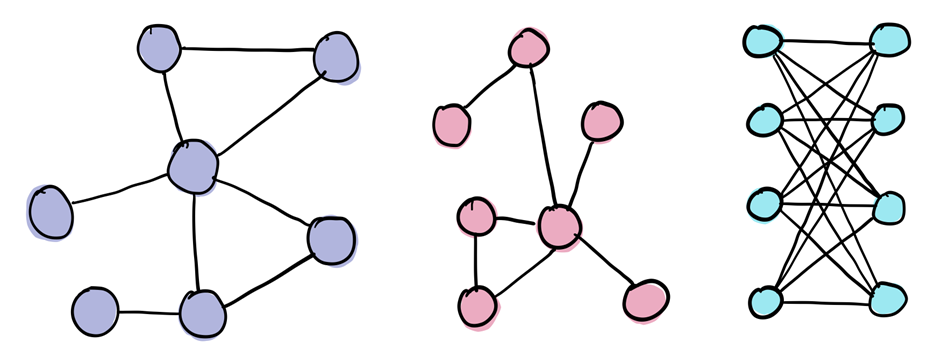

グラフは、相互接続された頂点 (ノード) の集合で構成されます。たとえば、6 ノードのグラフを以下に示します: 

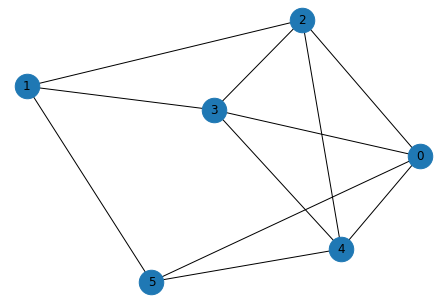

In [1]:
import networkx as nx

n_nodes = 6
p = 0.5  # probability of an edge
seed = 1967

g = nx.erdos_renyi_graph(n_nodes, p=p, seed=seed)
positions = nx.spring_layout(g, seed=seed)

nx.draw(g, with_labels=True, pos=positions, node_size=600)

多くの実用的なユースケースは、グラフ構造にマッピングできます。ソーシャルネットワークでは、グラフのノードはユーザーを表し、エッジはユーザー間の接続を表します。

グラフの重要な性質を理解するために、最適化問題を解く必要があることがよくあります。これらの問題の例として次のものが考えられます: 

- 全結合のノードで構成された大きなクラスターを見つける ([最大クリーク問題](https://ja.wikipedia.org/wiki/%E6%9C%80%E5%A4%A7%E3%82%AF%E3%83%AA%E3%83%BC%E3%82%AF%E5%95%8F%E9%A1%8C))
- グラフ内のすべてのエッジに接続する、最小の頂点部分集合を見つける ([最小頂点被覆問題](https://ja.wikipedia.org/wiki/%E6%9C%80%E5%B0%8F%E9%A0%82%E7%82%B9%E8%A2%AB%E8%A6%86%E5%95%8F%E9%A1%8C))
- 交差するエッジ数が最大になるように、ノードを2つの部分集合に分ける ([最大カット問題](https://ja.wikipedia.org/wiki/%E3%82%AB%E3%83%83%E3%83%88_(%E3%82%B0%E3%83%A9%E3%83%95%E7%90%86%E8%AB%96)))

このチュートリアルでは、QAOA と呼ばれるハイブリッドアルゴリズムを PennyLane と Braket で実行し、グラフ上の最適化問題を解く方法を示します。6ノードの小さなグラフから始めて、SV1 での並列実行を利用して 20 ノードのグラフまで試してみます。

## QAOA

量子近似最適化アルゴリズム (quantum approximate optimization algorithm; QAOA) は、短期的なハードウェア用に設計されたアルゴリズムです。グラフ上で定義された組合せ最適化問題などの近似解を求めることができます。

QAOA は Amazon Braket SDK を利用した [QAOA_braket](../Hybrid_quantum_Algorithms/Qaoa/qaoa_braket.ipynb) ノートブックや Pennylane の [tutorials](https://pennylane.ai/qml/demos/tutorial_qaoa_intro.html) でも説明されています。以下に、主要な概念をおさらいするための簡単なまとめを示します。


QAOA は、最適化問題をコストハミルトニアン $H_C$ に関連付けて、ミキサーハミルトニアン $H_{M}$ を選ぶことから始めます。これは下の図に示すように、制御可能なパラメータ $\gamma_i$ と $\alpha_i$ をもったユニタリー変換 $\exp {(-i\gamma_i H_C)}$ と $\exp {(-i\alpha_i H_M)}$ を複数のレイヤーで繰り返し適用することによって実行されます。

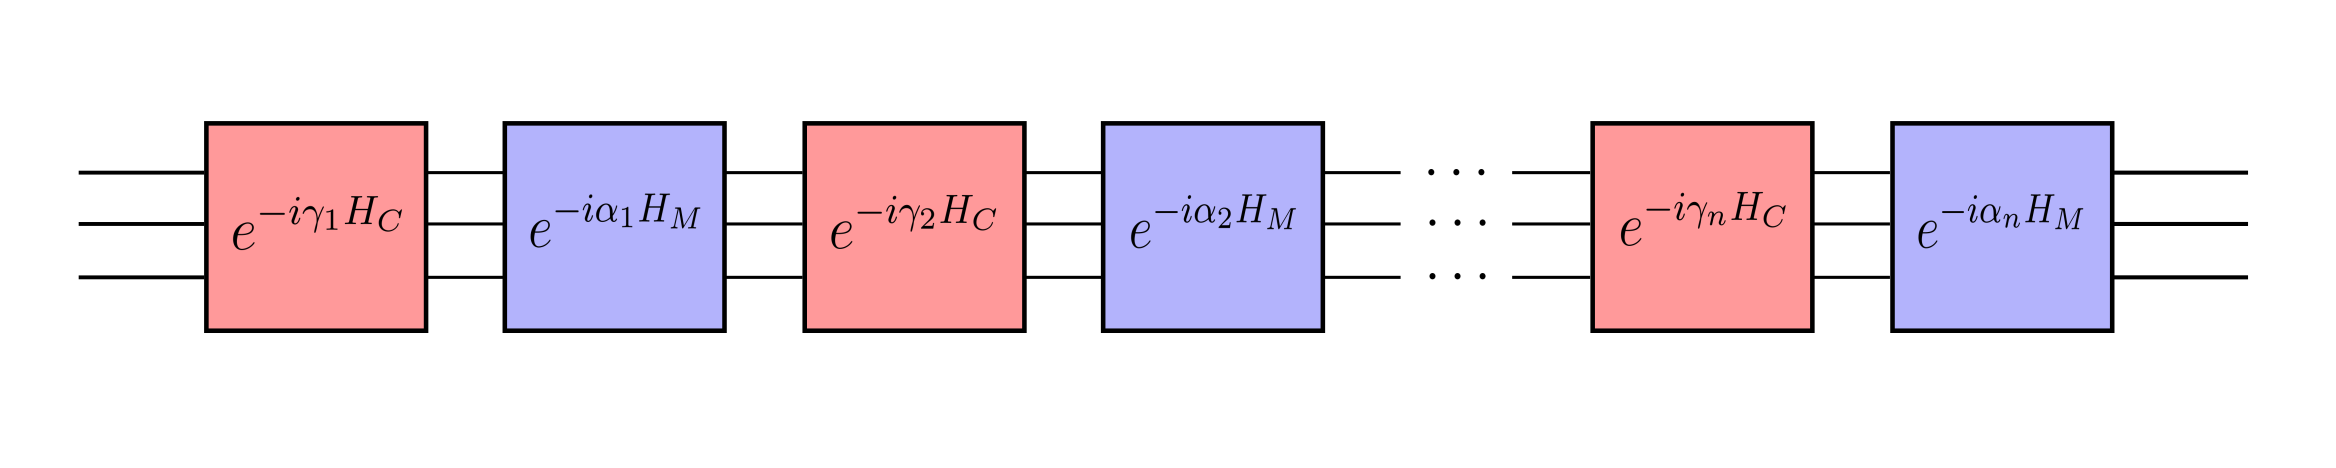

次に、アルゴリズムはコストハミルトニアン $H_C$ を測定します。制御可能なパラメータ $\gamma_i$ と $\alpha_i$ を変化させることで、コストハミルトニアンの期待値が最小化されます。最適化されたユニタリ変換を適用すると、最適解を与える変数に関する情報を含む量子状態が準備されます。その状態をサンプリングすると、解候補が得られます。

<div class="alert alert-block alert-info">
<b>要約</b> QAOA と量子アルゴリズムに慣れない方のために、重要なメッセージは、このアルゴリズムは量子回路が依存する制御可能なパラメータ $\gamma_i$ と $\alpha_i$ の最適化を行うということです。これは、Pennylane/Braket パイプラインを使用して自然に行うことができます。
</div>

## 問題設定

上のグラフについて、最大クリーク、すなわち全結合となっている最大の頂点部分集合を見つけてみましょう。

これを PennyLane と Braket で QAOA を使って解くには、まずコストハミルトニアン $H_C$ と対応するミキサーハミルトニアン $H_M$ を計算します。

In [2]:
import pennylane as qml
from pennylane import numpy as np

cost_h, mixer_h = qml.qaoa.max_clique(g, constrained=False)
# constrained=True results in greater circuit depth but potentially better solutions

print("Cost Hamiltonian:\n", cost_h)
print("Mixer Hamiltonian:\n", mixer_h)

Cost Hamiltonian:
 (0.75) [Z0 Z1]
+ (0.25) [Z0]
+ (-0.5) [Z1]
+ (0.75) [Z1 Z4]
+ (0.25) [Z4]
+ (0.75) [Z2 Z5]
+ (0.25) [Z2]
+ (-0.5) [Z5]
+ (0.75) [Z3 Z5]
+ (0.25) [Z3]
Mixer Hamiltonian:
 (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]
+ (1) [X4]
+ (1) [X5]


## アルゴリズムの設定

まず、単一の QAOA レイヤーを設定します。

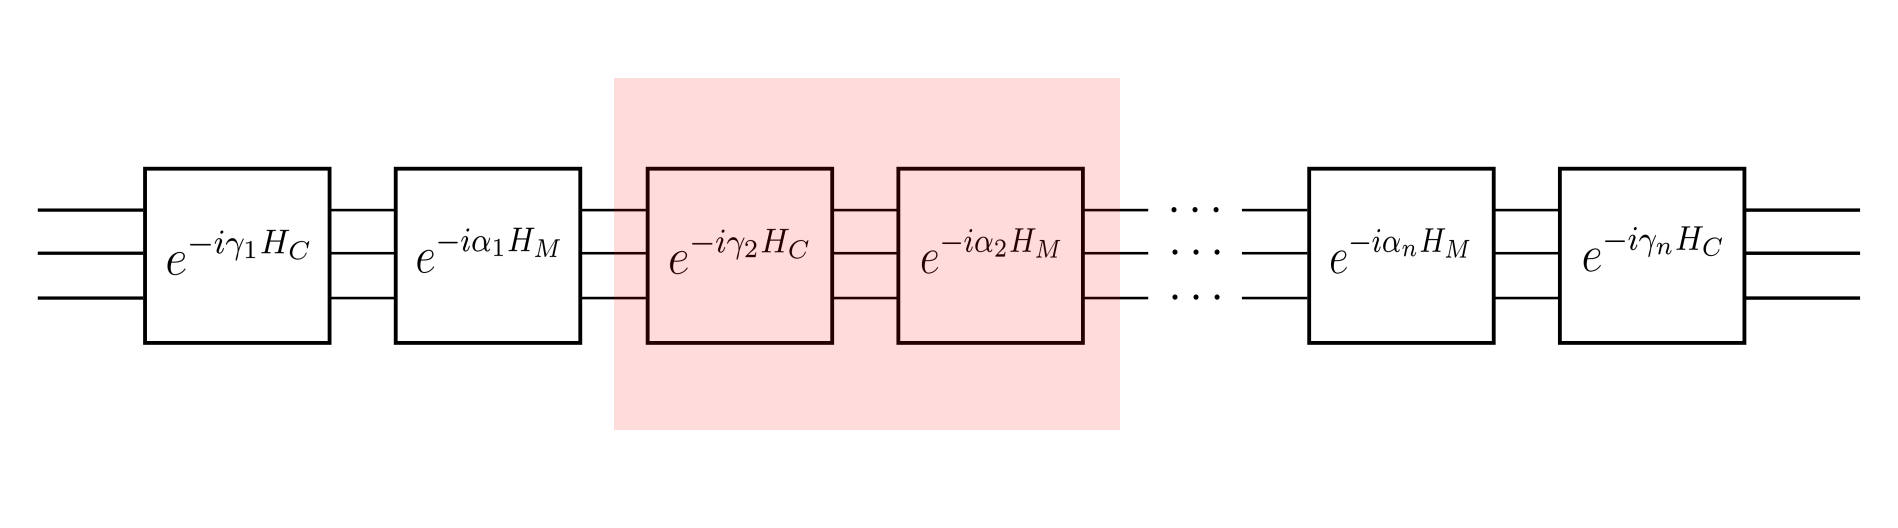

このレイヤーには、制御可能なパラメータ $\gamma_i$ と $\alpha_i$ が含まれます。

In [3]:
def qaoa_layer(gamma, alpha):
    qml.qaoa.cost_layer(gamma, cost_h)
    qml.qaoa.mixer_layer(alpha, mixer_h)

完全な QAOA 回路は次の式で与えられます: 

In [4]:
n_layers = 4
wires = n_nodes

def circuit(params, **kwargs):
    for i in range(wires):  # Prepare an equal superposition over all qubits
        qml.Hadamard(wires=i)
        
    qml.layer(qaoa_layer, n_layers, params[0], params[1])

<div class="alert alert-block alert-info">
<b>注:</b> 今回、4 つの QAOA レイヤーを使用することにしました。深さの選択は、(より深い回路による) より良い解と実行時間の増加との間のトレードオフで決定します。
</div>

全体で制御可能なパラメータは 8 つあります。最初の 4 つはコストハミルトニアンの $\gamma_i$ 用で、2 番目の 4 つはミキサーハミルトニアンの $\alpha_i$ 用です。

In [5]:
np.random.seed(1967)
params = np.random.uniform(size=[2, n_layers])
params

tensor([[0.72511958, 0.57312068, 0.6448612 , 0.55801009],
        [0.94368854, 0.93863944, 0.52819152, 0.5817428 ]], requires_grad=True)

本チュートリアルのこの部分では、ローカルの Braket シミュレータを使用します (詳細は [導入チュートリアル](./0_Getting_started.ipynb) を参照)。

In [6]:
dev = qml.device("braket.local.qubit", wires=wires)

最後のステップは、コスト関数を定義することです。QAOA では、出力コスト関数はコストハミルトニアン $H_C$ の期待値で与えられます。すなわち、

In [7]:
@qml.qnode(dev)
def cost_function(params, **kwargs):
    circuit(params)
    return qml.expval(cost_h)

## アルゴリズムの実行

ここまででコスト関数を定義したので、あとはオプティマイザを選択して最適化ループを実行するだけです。

In [8]:
optimizer = qml.GradientDescentOptimizer()

In [9]:
print("Initial cost:", cost_function(params))

for i in range(10):
    params = optimizer.step(cost_function, params)
    cost_eval = cost_function(params)
    print(f"Completed iteration {i + 1}, cost function:", cost_eval)

Initial cost: 0.6516478992954958
Completed iteration 1, cost function: -0.668741012754724
Completed iteration 2, cost function: -1.715907278390606
Completed iteration 3, cost function: -1.950115458213475
Completed iteration 4, cost function: -2.0330929514098757
Completed iteration 5, cost function: -2.1057100865780667
Completed iteration 6, cost function: -2.174831755527574
Completed iteration 7, cost function: -2.242888962573279
Completed iteration 8, cost function: -2.3112830459267624
Completed iteration 9, cost function: -2.3807887017553826
Completed iteration 10, cost function: -2.4517855696487607


## 結果の分析

アルゴリズムの実行がどの程度うまくいっているかをどうやって知ればいいでしょう？これを行うには、最適化されたパラメータを使用した回路からサンプリングします。これにより、最も一般的なサンプルを選択するか、対応するエネルギーが最も低いサンプルを選択するなど、クリークの一部として使用するグラフのノードを選択できるバイナリサンプルが得られます。

いくつかのサンプルを取得して、どのサンプルが最も頻繁に発生するかを見てみましょう。まず、サンプリング用に設計された QNode を作成します。

In [10]:
shots = 100000
dev = qml.device("braket.local.qubit", wires=wires, shots=shots)

@qml.qnode(dev)
def samples(params):
    circuit(params)
    return [qml.sample(qml.PauliZ(i)) for i in range(wires)]

サンプルを生成し、確率に変換します: 

In [11]:
from collections import Counter

s = samples(params).T
s = (1 - s.numpy()) / 2
s = map(tuple, s)

counts = Counter(s)
indx = np.ndindex(*[2] * wires)

probs = {p: counts.get(p, 0) / shots for p in indx}

これで、すべての可能なサンプルの確率分布をプロットできます。

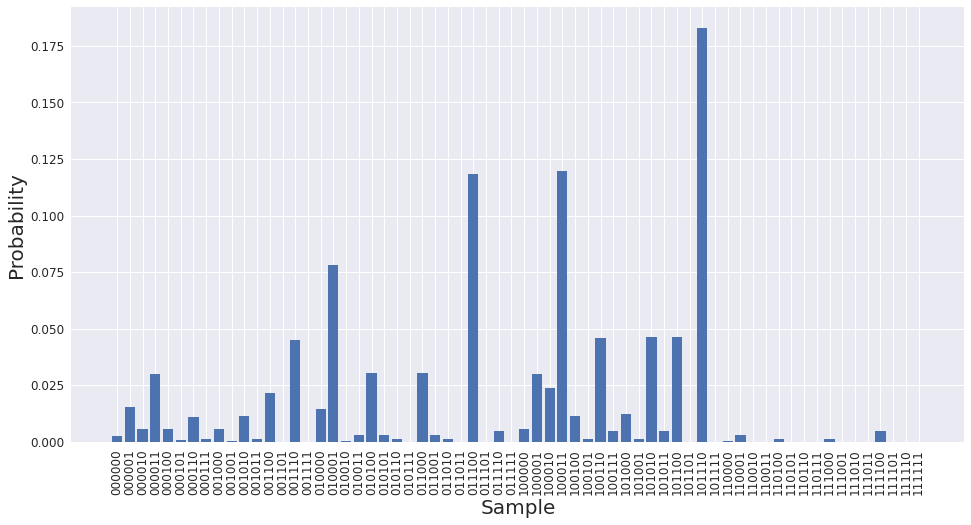

In [12]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
labels = ["{0:{fill}6b}".format(i, fill='0') for i in range(len(probs))]

plt.bar(range(2 ** wires), probs.values())
plt.xticks([i for i in range(len(probs))], labels, rotation='vertical', size=12)
plt.yticks(size=12)

plt.xlabel("Sample", size=20)
plt.ylabel("Probability", size=20)

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.show()

プロットから、サンプル ``101110`` が最も高い確率を持つことは明らかです。各量子ビットはノードに対応しているので、このサンプルはノード ``[0, 2, 3, 4]`` を選択して部分グラフを形成します。これがクリークであるかどうか、つまりすべてのノードが接続されているかどうかを調べてみましょう。

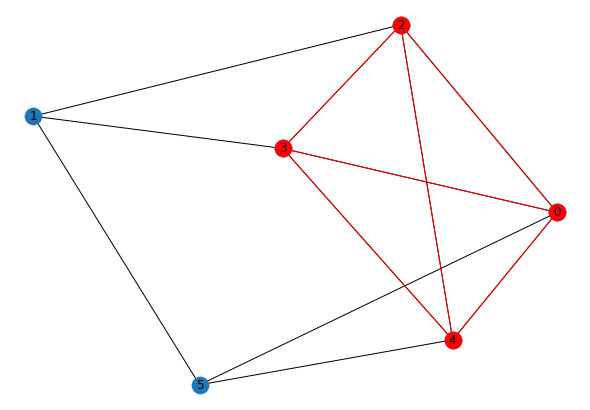

In [13]:
sub = g.subgraph([0, 2, 3, 4])
nx.draw(g, pos=positions, with_labels=True)
nx.draw(sub, pos=positions, node_color="r", edge_color="r")

素晴らしい、これはクリークですね！さらに、この6ノードグラフでは*最大*クリークとなっています。PennyLane と Braket を使用した QAOA で、最大クリーク問題を解くことができました！

## より大きなグラフへ QAOA のスケールアップ

Braket で PennyLane を使用し QAOA でグラフ最適化問題を解く方法を見てきました。ただし、これまでのところ、単純な 6 ノードグラフに制限したうえで、ローカル Braket デバイスを使用しました。それでは、もう少し野心的に、20 ノードグラフの最適化問題を解きましょう！

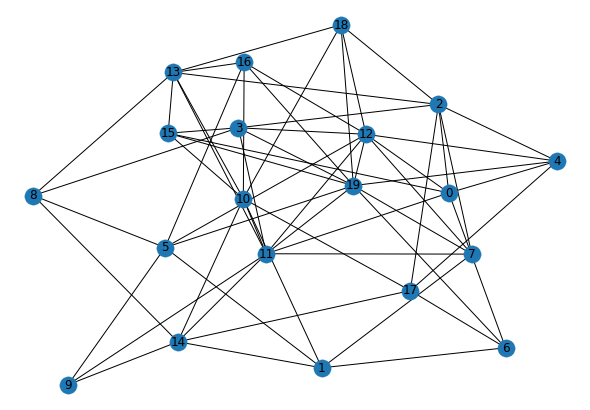

In [14]:
import networkx as nx

nodes = wires = 20
edges = 60
seed = 1967

g = nx.gnm_random_graph(nodes, edges, seed=seed)
positions = nx.spring_layout(g, seed=seed)

nx.draw(g, with_labels=True, pos=positions)

20 ノードのグラフ（同じ数の量子ビットにマッピングされます）を解こうとすると、ローカルシミュレータの実行が遅くなる領域に差し掛かります。[並列化のチュートリアル](./1_parallelized_optimization_of_quantum_circuits.ipynb) で説明したように、各最適化ステップでは勾配計算のため複数デバイスが実行され、回路を訓練する際は複合的な要因で実行が遅くなります。ありがたいことに、マネージド SV1 シミュレータは、勾配計算の並列化による高速化に適しています。これで、QAOA の回路の学習が妥当な時間内に解決可能になります。

まず、新しいデバイスを読み込みましょう。

In [15]:
device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"

In [16]:
dev = qml.device(
    "braket.aws.qubit",
    device_arn=device_arn,
    wires=wires,
    parallel=True,
    max_parallel=20,
    poll_timeout_seconds=30,
)

ここで、``max_parallel=20`` を指定していることに注意してください。これにより、SV1 で最大 ``20`` の回路が並列に実行されます (デフォルト値は ``10``)。

<div class="alert alert-block alert-warning">
<b>注:</b> 並列実行の最大数を増やすと、シミュレーション料金が高くなる可能性があります。また、<a href="https://docs.aws.amazon.com/braket/latest/developerguide/braket-quotas.html">サービスクォータ</a> を念頭に置いて設定する必要があります (AWS マネージメントコンソールの <a href="https://console.aws.amazon.com/servicequotas/home">ここ</a> にあります)。同様に、QAOA を QPU で実行する場合、待ち時間と <a href="https://aws.amazon.com/braket/pricing/">高額の使用料</a> が発生する可能性があります。 
</div>

今回も、QAOA 回路と最適化問題を以前と同じ方法で準備します。全く同じ問題設定だと面白くないので、ここでは新しい最適化問題に切り替えます。グラフのノードを2つのグループに分割して、グループ間を跨ぐエッジの数を最大化する、最大カット問題を解いてみましょう (下の画像を参照)。この問題は NP-hard であり、グラフのノード数を増やすにつれて急激に難しくなると予想されます。

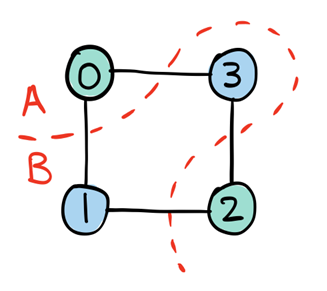

In [17]:
cost_h, mixer_h = qml.qaoa.maxcut(g)

In [18]:
def qaoa_layer(gamma, alpha):
    qml.qaoa.cost_layer(gamma, cost_h)
    qml.qaoa.mixer_layer(alpha, mixer_h)

In [19]:
n_layers = 2

@qml.qnode(dev)
def cost_function(params, **kwargs):
    for i in range(wires):  # Prepare an equal superposition over all qubits
        qml.Hadamard(wires=i)
        
    qml.layer(qaoa_layer, n_layers, params[0], params[1])
    return qml.expval(cost_h)

In [20]:
np.random.seed(1967)
params = 0.01 * np.random.uniform(size=[2, n_layers])

PennyLane にはさまざまな [オプティマイザ](https://pennylane.readthedocs.io/en/stable/introduction/optimizers.html) が用意されています。``adagradOptimizer`` を選んでみましょう:

In [22]:
optimizer = qml.AdagradOptimizer(stepsize=0.1)

これで回路を訓練する準備ができました！この回路を自分で訓練する場合は、最適化ループのイテレーション回数を増やしたり、QAOA 層数の変化を調べてみると良いでしょう。

<div class="alert alert-block alert-warning">
<b>注:</b> 次のセルの実行には時間がかかり、AWS アカウントに <a href="https://aws.amazon.com/braket/pricing/">使用料</a> が請求されます。待ち時間とコストが許容できる場合にのみ、セルのコメントを外してください。大量の量子ビットを含むジョブにはコストがかかることに注意し、AWS コンソールのマイ請求ダッシュボードをモニタリングすることをお勧めします。
</div>

In [23]:
# import time

# iterations = 10

# for i in range(iterations):    
#     t0 = time.time()
    
#     params, cost_before = optimizer.step_and_cost(cost_function, params)    

#     t1 = time.time()
    
#     if i == 0:
#         print("Initial cost:", cost_before)
#     else:
#         print(f"Cost at step {i}:", cost_before)

#     print(f"Completed iteration {i + 1}")
#     print(f"Time to complete iteration: {t1 - t0} seconds")

# print(f"Cost at step {iterations}:", cost_function(params))

# np.save("params.npy", params)
# print("Parameters saved to params.npy")

<code>
Initial cost: -29.98570234095951
Completed iteration 1
Time to complete iteration: 93.96246099472046 seconds
Cost at step 1: -27.154071768632154
Completed iteration 2
Time to complete iteration: 84.80994844436646 seconds
Cost at step 2: -29.98726230006233
Completed iteration 3
Time to complete iteration: 83.13504934310913 seconds
Cost at step 3: -29.999163153600062
Completed iteration 4
Time to complete iteration: 85.61391234397888 seconds
Cost at step 4: -30.002158646044307
Completed iteration 5
Time to complete iteration: 86.70688223838806 seconds
Cost at step 5: -30.012058444011906
Completed iteration 6
Time to complete iteration: 83.26341080665588 seconds
Cost at step 6: -30.063709712612443
Completed iteration 7
Time to complete iteration: 85.25566911697388 seconds
Cost at step 7: -30.32522304705352
Completed iteration 8
Time to complete iteration: 83.55433392524719 seconds
Cost at step 8: -31.411030331978186
Completed iteration 9
Time to complete iteration: 84.08745908737183 seconds
Cost at step 9: -33.87153965616938
Completed iteration 10
Time to complete iteration: 87.4032838344574 seconds
Cost at step 10: -36.05424874438809
Parameters saved to params.npy
</code>

この例では、20 量子ビットの QAOA 問題は、Amazon Braket SV1 デバイスで並列実行を使用して勾配計算を高速化することにより、イテレーションごとに約 1-2 分以内で訓練できることが示されました。この問題がローカルの Braket シミュレータで並列化されずに実行された場合、トレーニングにはかなり長い時間がかかることが予想されます。

30 イテレーション後の 2 層 QAOA 回路の事前最適化済みパラメータは、以下でロードできます。

In [24]:
params_30 = np.load("params_30.npy")

<div class="alert alert-block alert-info">
<b>次のステップは？</b> 以前の方法を適用し、20 ノードグラフでの学習済み QAOA 回路を分析できるか確認しましょう。また、量子化学に関するフォローアップチュートリアルもチェックしてください。
</div>

In [ ]:
print("Task Summary")
print(t.quantum_tasks_statistics())
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.3f} USD")